Le prix obtenu par Monte-Carlo est : 0.12504191363891692
Le prix théorique est : 0.1250582645361391
La marge d'erreur est : 0.00028254670339661336


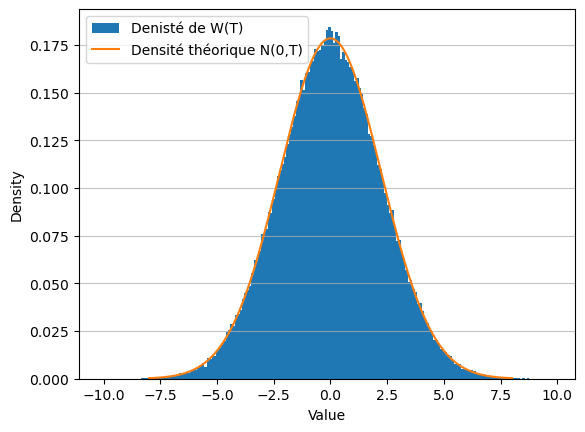

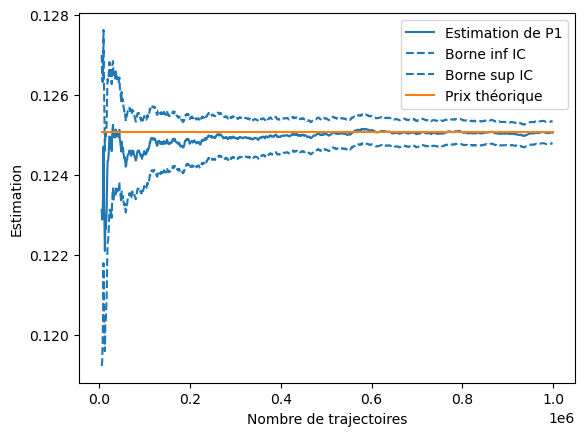

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import newton
#plt.style.use('seaborn')

rng = npr.default_rng(42)

#simulation de W(T) par Box-Muller
def brownien_WT(n,T):
    U=npr.random(n)
    V=npr.random(n)
    X=np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
    Y=np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)
    Z=np.concatenate((X,Y)) 
    W_T=np.sqrt(T)*Z
    return W_T
n=100000
T=5
W_T=brownien_WT(n,T)
x=np.linspace(-8,8,n)
y=np.exp(-(x**2)/(2*T))/np.sqrt(2*np.pi*T)
plt.hist(W_T, bins='auto',density='True',label='Denisté de W(T)')
plt.grid(axis='y', alpha=0.75)
plt.plot(x,y,label='Densité théorique N(0,T)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()


#approximation gaussienne
def repartition_gaussienne(x):
        b0=0.2316419
        b1 = 0.319381530
        b2 = -0.356563782
        b3 = 1.781477937
        b4 = -1.821255978
        b5 = 1.330274429
        t = 1/(1+b0*abs(x))
        y = (1 - np.exp(-0.5*x**2)*(b1*t+b2*t**2+b3*t**3+b4*t**4+b5*t**5)/np.sqrt(2*np.pi))*(x>0) + (np.exp(-0.5*x**2)*(b1*t+b2*t**2+b3*t**3+b4*t**4+b5*t**5)/np.sqrt(2*np.pi))*(x<0)
        return y
    
#simulation de P_1
def calcul_P1(r,s,S0,K,T,N):
    n=N//2
    W_T=brownien_WT(n,T)
    S_T=S0*np.exp((r-(s**2)/2)*T + s*W_T)
    payoff=np.exp(-r*T)*np.maximum(K-S_T,0) 
    P1=np.mean(payoff) #monte-carlo pour estimer l'espérance

    #intervalle de confiance à 90%
    u=np.arange(5000,N,1000)
    MC_price=np.cumsum(payoff)[u]/u
    sigma2=(u/(u-1))*(np.cumsum(payoff**2)[u]/u - MC_price**2) #estimateur sans biais de la variance
    sigma=np.sqrt(sigma2)
    borne_inf=MC_price -1.645*sigma/np.sqrt(u)
    borne_sup=MC_price +1.645*sigma/np.sqrt(u)
    
    #valeur théorique
    d1 = (np.log(K/S0)-(r-s**2/2)*T)/(s*np.sqrt(T))
    d2 = d1 - s*np.sqrt(T)
    P_th = K*np.exp(-r*T)*repartition_gaussienne(d1) - S0*repartition_gaussienne(d2)
    
    return P1, P_th, borne_sup, borne_inf, MC_price

N=1000000
r=0.02
s=0.2 #volatilité
S0=1
K=1
T=5
[P1,P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,S0,K,T,N)   
print("Le prix obtenu par Monte-Carlo est :", P1)
print("Le prix théorique est :", P_th)
print("La marge d'erreur est :", borne_sup[-1]-P1)
#visualisation
plt.figure()
u=np.arange(5000,N,1000)
plt.plot(u, MC_price, 'C0', label='Estimation de P1')
plt.plot(u, borne_inf, 'C0--', label='Borne inf IC')
plt.plot(u, borne_sup, 'C0--', label= 'Borne sup IC')
plt.plot(u, P_th*np.ones_like(u), 'C1', label='Prix théorique')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Estimation')
plt.legend()

In [2]:
#calcul numérique de K barre
def function_ST1(ST1,T1,T2,r,K,s):
    d1 = 1/(s*np.sqrt(T2-T1))*(np.log(K/ST1)-(r-s**2/2)*(T2-T1))
    d2=d1-s*np.sqrt(T2-T1)
    Pe = K*np.exp(-r*(T2-T1))*repartition_gaussienne(d1) -ST1*repartition_gaussienne(d2)  #prix option européenne
    payoff = K-ST1
    return Pe-payoff

def calcul_K(T1,T2,r,K,s):
    K_barre = newton(function_ST1,x0=1,args=(T1,T2,r,K,s),maxiter=500)
    return K_barre
   
K_barre = calcul_K(3,5,r,K,s)
print("Une valeur approchée de K barre est :", K_barre)

Une valeur approchée de K barre est : 0.8023861844166125


Le prix obtenu par Monte-Carlo est : 0.1314221606285113
La marge d'erreur est : 0.0002543314690506837


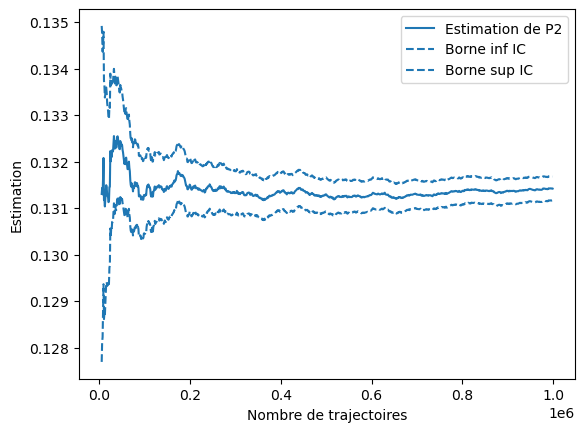

In [3]:
#simulation de W
def mvmt_brownien(T1,T2,N):
    #box-muller
    n=N//2
    U=npr.random((2,n))
    V=npr.random((2,n))
    X=np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
    Y=np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)
    G=np.concatenate((X,Y),axis=1) 
    #par matrice de covariance
    #A = np.array([[np.sqrt(T1),0],[np.sqrt(T1),np.sqrt(T2-T1)]])
    #Z = A @ G
    #alternative accroissements indépendants
    t=np.reshape(np.array([T1,T2-T1]),(2,1))
    G1=np.sqrt(t)*G
    Z=np.cumsum(G1,axis=0)
    return Z

def calcul_P2(T1,T2,r,K,s,S0,N):
    W=mvmt_brownien(T1, T2, N)
    W_T1 = W[0,:]
    W_T2 = W[1,:]
    ST1 = S0*np.exp((r-(s**2)/2)*T1 + s*W_T1)
    ST2 = S0*np.exp((r-(s**2)/2)*T2 + s*W_T2)
    K_barre = calcul_K(T1, T2, r, K, s)
   
    payoff2 = np.exp(-r*T2)*np.maximum(K-ST2,0)*(ST1>=K_barre)
    payoff1 = np.exp(-r*T1)*(K-ST1)*(ST1<K_barre)
    payoff = payoff1+payoff2
    P2=np.mean(payoff)
    u=np.arange(5000,N,1000)
    MC_price=np.cumsum(payoff)[u]/u;
    sigma2=(u/(u-1))*np.cumsum(payoff**2)[u]/u - MC_price**2;
    sigma=np.sqrt(sigma2);
    borne_inf=MC_price -1.645*sigma/np.sqrt(u);
    borne_sup=MC_price +1.645*sigma/np.sqrt(u);
    
    return P2, borne_sup, borne_inf, MC_price

T1=3
T2=5
N=1000000
r=0.02
s=0.2 #volatilité
S0=1
K=1
P2, borne_sup, borne_inf, MC_price = calcul_P2(T1, T2, r, K, s, S0, N)
print("Le prix obtenu par Monte-Carlo est :", P2)
print("La marge d'erreur est :", borne_sup[-1]-P2)
plt.figure()
u=np.arange(5000,N,1000)
plt.plot(u, MC_price, 'C0', label='Estimation de P2')
plt.plot(u, borne_inf, 'C0--', label='Borne inf IC')
plt.plot(u, borne_sup, 'C0--', label= 'Borne sup IC')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Estimation')
plt.legend()

Le prix obtenu par Monte-Carlo  avec réduction de variance est : 0.1312002536718836
La marge d'erreur avec RV est : 0.00011066619662628008


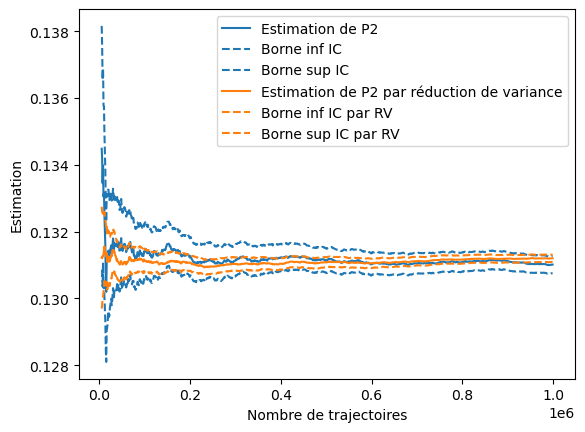

In [4]:
def calcul_P2_RV(T1,T2,r,K,s,S0,N):
    W=mvmt_brownien(T1, T2, N)
    W_T1 = W[0,:]
    W_T2 = W[1,:]
    
    #sans réduction de variance
    ST1 = S0*np.exp((r-(s**2)/2)*T1 + s*W_T1)
    ST2 = S0*np.exp((r-(s**2)/2)*T2 + s*W_T2)
    K_barre = calcul_K(T1, T2, r, K, s)
    
    payoff2 = np.exp(-r*T2)*np.maximum(K-ST2,0)*(ST1>=K_barre)
    payoff1 = np.exp(-r*T1)*(K-ST1)*(ST1<K_barre)
    payoff = payoff1+payoff2
    
    P2=np.mean(payoff)
    u=np.arange(5000,N,1000)
    MC_price=np.cumsum(payoff)[u]/u;
    sigma2=u/(u-1)*np.cumsum(payoff**2)[u]/u - MC_price**2;
    sigma=np.sqrt(sigma2);
    borne_inf=MC_price -1.645*sigma/np.sqrt(u);
    borne_sup=MC_price +1.645*sigma/np.sqrt(u);
    
    #avec reduction de variance
    ST1_a = S0*np.exp((r-(s**2)/2)*T1 + s*(-W_T1))
    ST2_a = S0*np.exp((r-(s**2)/2)*T2 + s*(-W_T2))
    
    payoff2_a = np.exp(-r*T2)*np.maximum(K-ST2_a,0)*(ST1_a>=K_barre)
    payoff1_a = np.exp(-r*T1)*(K-ST1_a)*(ST1_a<K_barre)
    payoff_a = (payoff + payoff2_a + payoff1_a)/2
    
    P2_a=np.mean(payoff_a)
    MC_price_a=np.cumsum(payoff_a)[u]/u;
    sigma2_a=(u/(u-1))*np.cumsum(payoff_a**2)[u]/u - MC_price_a**2;
    sigma_a=np.sqrt(sigma2_a);
    borne_inf_a=MC_price_a -1.645*sigma_a/np.sqrt(u);
    borne_sup_a=MC_price_a +1.645*sigma_a/np.sqrt(u);
    
    return P2, borne_sup, borne_inf, MC_price, P2_a, borne_sup_a, borne_inf_a, MC_price_a

T1=3
T2=5
N=1000000
r=0.02
s=0.2 #volatilité
S0=1
K=1
P2, borne_sup, borne_inf, MC_price, P2_a, borne_sup_a, borne_inf_a, MC_price_a = calcul_P2_RV(T1, T2, r, K, s, S0, N)
print("Le prix obtenu par Monte-Carlo  avec réduction de variance est :", P2_a)
print("La marge d'erreur avec RV est :", borne_sup_a[-1]-P2_a)
#visualisation
plt.figure()
u=np.arange(5000,N,1000)
plt.plot(u, MC_price, 'C0', label='Estimation de P2')
plt.plot(u, borne_inf, 'C0--', label='Borne inf IC')
plt.plot(u, borne_sup, 'C0--', label= 'Borne sup IC')
plt.plot(u, MC_price_a, 'C1', label='Estimation de P2 par réduction de variance')
plt.plot(u, borne_inf_a, 'C1--', label='Borne inf IC par RV')
plt.plot(u, borne_sup_a, 'C1--', label= 'Borne sup IC par RV')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Estimation')
plt.legend()

In [5]:
def choix_N_P2(T1,T2,r,K,s,S0,N,tol):
    P2, borne_sup, borne_inf, MC_price, P2_a, borne_sup_a, borne_inf_a, MC_price_a = calcul_P2_RV(T1, T2, r, K, s, S0, N)
    u=np.arange(5000,N,1000)
    e=(borne_sup_a-borne_inf_a)/2 #erreur
    index=int(np.argwhere(e<tol)[0]) #indice de la première valeur de N telle que l'erreur soit inférieure au seuil
    return u[index]

On choisit Nt= 298000


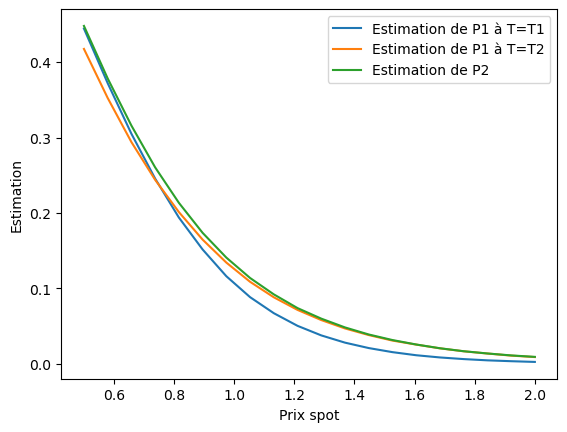

In [6]:
tol=2e-4
Nt=choix_N_P2(T1,T2,r,K,s,S0,N,tol)
print("On choisit Nt=",Nt)
M=20
Spot=np.linspace(0.5,2,M)
P2_a=np.zeros(M)
P1_1=np.zeros(M)
P1_2=np.zeros(M)
for i in range(M):
    [P1_1[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,Spot[i],K,T1,Nt)
    [P1_2[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,Spot[i],K,T2,Nt)
    [P2, borne_sup, borne_inf, MC_price, P2_a[i], borne_sup_a, borne_inf_a, MC_price_a]= calcul_P2_RV(T1, T2, r, K, s, Spot[i], Nt)
plt.figure()
plt.plot(Spot,P1_1,'C0',label='Estimation de P1 à T=T1')
plt.plot(Spot,P1_2,'C1',label='Estimation de P1 à T=T2')
plt.plot(Spot,P2_a,'C2',label='Estimation de P2')
plt.xlabel('Prix spot')
plt.ylabel('Estimation')
plt.legend()

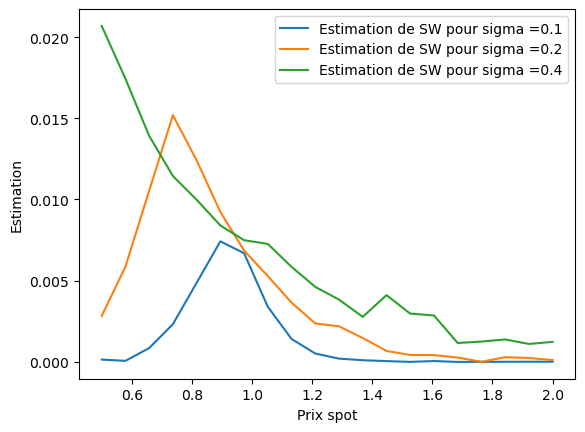

In [7]:
M=20
Spot=np.linspace(0.5,2,M)
sigma=[0.1,0.2,0.4]
SW=np.zeros(M)
P2_a=np.zeros(M)
P1_1=np.zeros(M)
P1_2=np.zeros(M)
plt.figure()
for j in range(3):
    for i in range(M):
        [P1_1[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,sigma[j],Spot[i],K,T1,Nt)
        [P1_2[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,sigma[j],Spot[i],K,T2,Nt)
        [P2, borne_sup, borne_inf, MC_price, P2_a[i], borne_sup_a, borne_inf_a, MC_price_a]= calcul_P2_RV(T1, T2, r, K, sigma[j], Spot[i], Nt)
    SW=P2_a - np.maximum(P1_1,P1_2)
    plt.plot(Spot,SW,label='Estimation de SW pour sigma ='+ str(sigma[j]))               
    plt.xlabel('Prix spot')
    plt.ylabel('Estimation')
    plt.legend()

Une estimation de K tilde est : 0.7457953816554895
Le prix obtenu par Monte-Carlo est : 0.1321340918447904
La marge d'erreur est : 0.00010128557163513463


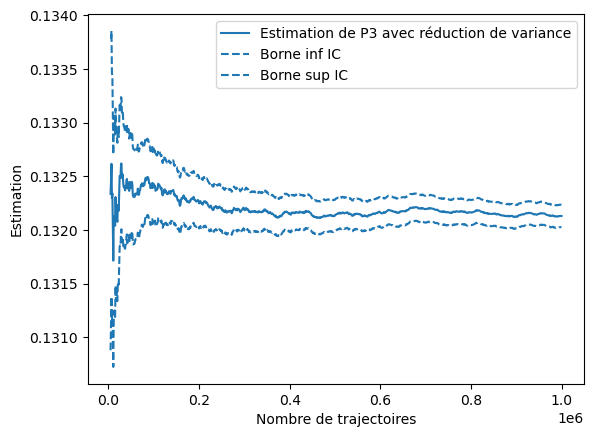

In [8]:
#Longstaff-Schwarz
def LS_Reg(T1,T2,T3,r,K,s,S0,N):
    n=N//2
    S1=S0*np.exp((r-(s**2)/2)*T1 + s*brownien_WT(n,T1))
    S2=S1*np.exp((r-(s**2)/2)*(T2-T1) + s*brownien_WT(n,T2-T1))
    S3=S2*np.exp((r-(s**2)/2)*(T3-T2) + s*brownien_WT(n,T3-T2))
    #formule fermée pour la valeur de continuation en T2
    d1 = (np.log(K/S2)-(r-s**2/2)*(T3-T2))/(s*np.sqrt(T3-T2))
    d2 = d1 - s*np.sqrt(T3-T2)
    Continuation_T2 = K*np.exp(-r*(T3-T2))*repartition_gaussienne(d1) - S2*repartition_gaussienne(d2)
    
    P2_T2=np.maximum(K-S2,Continuation_T2)
    S1=np.reshape(S1,(S1.size,1))
    Base=S1**np.arange(4)
    A=np.cov(Base,rowvar=False)
    A[0]=np.mean(Base,axis=0)
    B=np.cov(Base,P2_T2,rowvar=False)[-1,:4]
    B[0]=np.mean(P2_T2)
    Reg=np.linalg.solve(A,B)
    Var_Reg=np.var(P2_T2-np.dot(Base,Reg))
    return Reg, Var_Reg

#estimation numérique de K tilde
def function_ST1_tilde(S1,T1,T2,Reg,r,K,s):
    S=S1**np.arange(4)
    Pb = np.exp(-r*(T2-T1))*np.dot(S,Reg) #estomation du prix P2 en T1
    payoff = K-S1
    return Pb-payoff

def calcul_K_tilde(T1,T2,Reg,r,K,s):
    K_tilde = newton(function_ST1_tilde,x0=1,args=(T1,T2,Reg,r,K,s),maxiter=500)
    return K_tilde

T1=1
T2=3
T3=5
Reg,Var_Reg=LS_Reg(T1,T2,T3,r,K,s,S0,N)
K_tilde = calcul_K_tilde(T1, T2, Reg, r, K, s)
print("Une estimation de K tilde est :", K_tilde)


def calcul_P3_RV(T1,T2,T3,r,K,s,S0,N):
    Reg,Var_Reg=LS_Reg(T1,T2,T3,r,K,s,S0,N)
    K_barre = calcul_K(T2, T3, r, K, s)
    K_tilde = calcul_K_tilde(T1, T2, Reg, r, K, s)
    
    n=N//2
    W1=brownien_WT(n,T1)
    W2_1=brownien_WT(n,T2-T1)
    W3_2=brownien_WT(n,T3-T2)
    S1=S0*np.exp((r-(s**2)/2)*T1 + s*W1)
    S2=S1*np.exp((r-(s**2)/2)*(T2-T1) + s*W2_1)
    S3=S2*np.exp((r-(s**2)/2)*(T3-T2) + s*W3_2)
    
    payoff3 = np.exp(-r*T3)*np.maximum(K-S3,0)*(S2>=K_barre)*(S1>=K_tilde)
    payoff2 = np.exp(-r*T2)*(K-S2)*(S2<K_barre)*(S1>=K_tilde)
    payoff1 = np.exp(-r*T1)*(K-S1)*(S1<K_tilde)
    payoff = payoff1+payoff2+payoff3

    
    #avec reduction de variance
    S1_a=S0*np.exp((r-(s**2)/2)*T1 - s*W1)
    S2_a=S1_a*np.exp((r-(s**2)/2)*(T2-T1) - s*W2_1)
    S3_a=S2_a*np.exp((r-(s**2)/2)*(T3-T2) - s*W3_2)
     
    payoff3_a = np.exp(-r*T3)*np.maximum(K-S3_a,0)*(S2_a>=K_barre)*(S1_a>=K_tilde)
    payoff2_a = np.exp(-r*T2)*(K-S2_a)*(S2_a<K_barre)*(S1_a>=K_tilde)
    payoff1_a = np.exp(-r*T1)*(K-S1_a)*(S1_a<K_tilde)
    payoff_a = (payoff + payoff3_a + payoff2_a + payoff1_a)/2
    #payoff_a=payoff
    P3=np.mean(payoff_a)
    
    u=np.arange(5000,N,1000)
    MC_price_a=np.cumsum(payoff_a)[u]/u;
    sigma2_a=(u/(u-1))*np.cumsum(payoff_a**2)[u]/u - MC_price_a**2;
    sigma_a=np.sqrt(sigma2_a);
    borne_inf_a=MC_price_a -1.645*sigma_a/np.sqrt(u);
    borne_sup_a=MC_price_a +1.645*sigma_a/np.sqrt(u);
    
    return P3, borne_sup_a, borne_inf_a, MC_price_a
#visualisation
T1=1
T2=3
T3=5
N=1000000
r=0.02
s=0.2 #volatilité
S0=1
K=1
P3, borne_sup_a, borne_inf_a, MC_price_a = calcul_P3_RV(T1, T2, T3, r, K, s, S0, N)
print("Le prix obtenu par Monte-Carlo est :", P3)
print("La marge d'erreur est :", borne_sup_a[-1]-P3)
plt.figure()
u=np.arange(5000,N,1000)
plt.plot(u, MC_price_a, 'C0', label='Estimation de P3 avec réduction de variance')
plt.plot(u, borne_inf_a, 'C0--', label='Borne inf IC')
plt.plot(u, borne_sup_a, 'C0--', label= 'Borne sup IC')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Estimation')
plt.legend()

In [9]:
def choix_N_P3(T1,T2,T3,r,K,s,S0,N,tol):
    P3, borne_sup_a, borne_inf_a, MC_price_a = calcul_P3_RV(T1, T2, T3, r, K, s, S0, N)
    u=np.arange(5000,N,1000)
    e=(borne_sup_a-borne_inf_a)/2
    index=int(np.argwhere(e<tol)[0])
    return u[index]

On choisit Nt= 273000


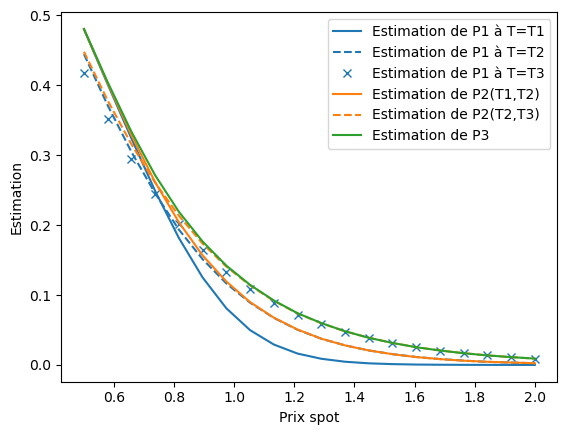

In [10]:
tol=2e-4
Nt=choix_N_P3(T1,T2,T3,r,K,s,S0,N,tol)
print("On choisit Nt=",Nt)
M=20
Spot=np.linspace(0.5,2,M)
P3=np.zeros(M)
P2_3=np.zeros(M)
P2_2=np.zeros(M)
P1_3=np.zeros(M)
P1_1=np.zeros(M)
P1_2=np.zeros(M)
for i in range(M):
    [P1_1[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,Spot[i],K,T1,Nt)
    [P1_2[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,Spot[i],K,T2,Nt)
    [P1_3[i],P_th,borne_sup, borne_inf, MC_price]=calcul_P1(r,s,Spot[i],K,T3,Nt)
    [P2, borne_sup, borne_inf, MC_price, P2_2[i], borne_sup_a, borne_inf_a, MC_price_a]= calcul_P2_RV(T1, T2, r, K, s, Spot[i], Nt)
    [P2, borne_sup, borne_inf, MC_price, P2_3[i], borne_sup_a, borne_inf_a, MC_price_a]= calcul_P2_RV(T2, T3, r, K, s, Spot[i], Nt)
    [P3[i], borne_sup_a, borne_inf_a, MC_price_a] = calcul_P3_RV(T1, T2, T3, r, K, s, Spot[i], Nt)
plt.figure()
plt.plot(Spot,P1_1,'C0',label='Estimation de P1 à T=T1')
plt.plot(Spot,P1_2,'C0--',label='Estimation de P1 à T=T2')
plt.plot(Spot,P1_3,'C0x',label='Estimation de P1 à T=T3')
plt.plot(Spot,P2_2,'C1',label='Estimation de P2(T1,T2)')
plt.plot(Spot,P2_3,'C1--',label='Estimation de P2(T2,T3)')
plt.plot(Spot,P3,'C2',label='Estimation de P3')
plt.xlabel('Prix spot')
plt.ylabel('Estimation')
plt.legend()

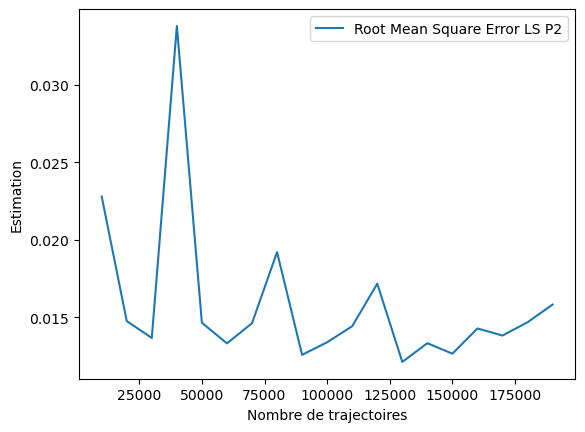

In [11]:
#Longstaff-Schwarz pour P2
def LS_Reg_P2(T1,T2,r,K,s,S0,N):
    n=N//2
    S1=S0*np.exp((r-(s**2)/2)*T1 + s*brownien_WT(n,T1))
    S2=S1*np.exp((r-(s**2)/2)*(T2-T1) + s*brownien_WT(n,T2-T1))
    
    P1_T2=np.maximum(K-S2,0)
    
    S1=np.reshape(S1,(S1.size,1))
    Base=S1**np.arange(4)
    A=np.cov(Base,rowvar=False)
    A[0]=np.mean(Base,axis=0)
    B=np.cov(Base,P1_T2,rowvar=False)[-1,:4]
    B[0]=np.mean(P1_T2)
    Reg=np.linalg.solve(A,B)
    Var_Reg=np.var(P1_T2-np.dot(Base,Reg))
    return Reg, Var_Reg


def eval_LS_P2(T1,T2,r,K,s,S0,N):
    Reg,Var_Reg=LS_Reg_P2(T1,T2,r,K,s,S0,N)
    
    n=N//2
    W1=brownien_WT(n,T1)
    W2_1=brownien_WT(n,T2-T1)
    S1=S0*np.exp((r-(s**2)/2)*T1 + s*W1)
    #S2=S1*np.exp((r-(s**2)/2)*(T2-T1) + s*W2_1)
    
    S1=np.reshape(S1,(S1.size,1))
    Base=S1**np.arange(4)
    
    P1_reg=np.exp(-r*(T2-T1))*np.dot(Base,Reg)
    #formule fermée pour la valeur de continuation en T1
    d1 = (np.log(K/S1)-(r-s**2/2)*(T2-T1))/(s*np.sqrt(T2-T1))
    d2 = d1 - s*np.sqrt(T2-T1)
    P1_T1 = K*np.exp(-r*(T2-T1))*repartition_gaussienne(d1) - S1*repartition_gaussienne(d2)
    P1_reg=np.reshape(P1_reg,(S1.size,1))
    #e=np.linalg.norm(P1_reg-P1_T1)/np.linalg.norm(P1_T1)
    e=np.sqrt(np.mean((P1_reg-P1_T1)**2))
    return e
#visualisation
T1=3
T2=5
N=200000
r=0.02
s=0.2 #volatilité
S0=1
K=1
vfunc = np.vectorize(eval_LS_P2,excluded=['T1','T2','r','K','s','S0'])
plt.figure()
U=np.arange(10000,N,10000)
e = vfunc(T1, T2, r, K, s, S0, U)
plt.plot(U,e, 'C0', label='Root Mean Square Error LS P2')
plt.xlabel('Nombre de trajectoires')
plt.ylabel('Estimation')
plt.legend()